<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [ ]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [ ]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text = article_text.replace("\n", "")
    article_text += para.text.replace("\r", "") + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [ ]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró rápidamente a su hogar, situado en el número 19 de la könig‑strasse, una de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se había retrasado, pues apenas empezaba a cocinar la comida en el hornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar la de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista todavía, porque es temprano, aún no son las dos. acaba de dar la media hora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —él lo explicará, seguramente. —¡ahí viene! yo me escapo. señor axel, cálmelo usted, por favor. y la excelente marta se retiró presurosa a su recinto culinario, dejándo

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [ ]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

76

In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [ ]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [ ]:
tokenized_text[:1000]

[52,
 46,
 2,
 52,
 55,
 27,
 15,
 3,
 18,
 22,
 27,
 52,
 9,
 73,
 52,
 55,
 46,
 52,
 15,
 62,
 67,
 27,
 52,
 55,
 46,
 52,
 57,
 31,
 34,
 5,
 50,
 52,
 15,
 3,
 52,
 75,
 39,
 27,
 50,
 52,
 46,
 2,
 52,
 38,
 45,
 27,
 29,
 46,
 0,
 27,
 45,
 52,
 2,
 3,
 55,
 46,
 18,
 20,
 45,
 27,
 17,
 69,
 50,
 52,
 46,
 18,
 75,
 45,
 6,
 52,
 45,
 10,
 38,
 3,
 55,
 62,
 15,
 46,
 18,
 75,
 46,
 52,
 62,
 52,
 0,
 70,
 52,
 36,
 27,
 22,
 62,
 45,
 50,
 52,
 0,
 3,
 75,
 70,
 62,
 55,
 27,
 52,
 46,
 18,
 52,
 46,
 2,
 52,
 18,
 7,
 15,
 46,
 45,
 27,
 52,
 57,
 33,
 52,
 55,
 46,
 52,
 2,
 62,
 52,
 69,
 1,
 18,
 3,
 22,
 4,
 0,
 75,
 45,
 62,
 0,
 0,
 46,
 50,
 52,
 70,
 18,
 62,
 52,
 55,
 46,
 52,
 2,
 62,
 0,
 52,
 17,
 62,
 2,
 2,
 46,
 0,
 52,
 15,
 10,
 0,
 52,
 75,
 45,
 62,
 55,
 3,
 17,
 3,
 27,
 18,
 62,
 2,
 46,
 0,
 52,
 55,
 46,
 2,
 52,
 20,
 62,
 45,
 45,
 3,
 27,
 52,
 62,
 18,
 75,
 3,
 22,
 70,
 27,
 52,
 55,
 46,
 52,
 36,
 62,
 15,
 20,
 70,
 45,
 22,
 27,
 25,
 52,
 

### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [ ]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [ ]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
X.shape

(381391, 100)

In [ ]:
X[0,:10]

array([52, 46,  2, 52, 55, 27, 15,  3, 18, 22])

In [ ]:
y[0,:10]

array([46,  2, 52, 55, 27, 15,  3, 18, 22, 27])

In [ ]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [ ]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 76)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          55,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 76)            │          15,276 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,676 (276.08 KB)

 Trainable params: 70,676 (276.08 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9440


 mean perplexity: 5.527632258729298 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 1.9439
Epoch 2/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8360


 mean perplexity: 5.200458341498639 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - loss: 1.8360
Epoch 3/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7882


 mean perplexity: 5.081471314081697 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - loss: 1.7882
Epoch 4/20
1489/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7613


 mean perplexity: 5.028384765172441 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 1.7613
Epoch 5/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7429
 mean perplexity: 5.044812689793446 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - loss: 1.7429
Epoch 6/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7306


 mean perplexity: 5.024554963656933 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 1.7306
Epoch 7/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7202
 mean perplexity: 5.038566496792801 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 1.7202
Epoch 8/20
1489/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7121


 mean perplexity: 5.020940339728182 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - loss: 1.7121
Epoch 9/20
1489/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7057


 mean perplexity: 4.990675403249153 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.7057
Epoch 10/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7003
 mean perplexity: 5.003893942788884 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - loss: 1.7003
Epoch 11/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6960


 mean perplexity: 4.9797269500903685 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.6960
Epoch 12/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6914


 mean perplexity: 4.952039463254617 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 1.6914
Epoch 13/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6876


 mean perplexity: 4.919298009694251 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 1.6876
Epoch 14/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6842


 mean perplexity: 4.880303586532675 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 1.6842
Epoch 15/20
1489/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6823
 mean perplexity: 4.904105563871786 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 1.6823
Epoch 16/20
1489/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6803


 mean perplexity: 4.866037979148808 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 1.6803
Epoch 17/20
1487/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6778


 mean perplexity: 4.863924005268042 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 1.6778
Epoch 18/20
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6757


 mean perplexity: 4.800606673966071 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 1.6757
Epoch 19/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6736
 mean perplexity: 4.810733804246905 

1490/1490 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 1.6736
Epoch 20/20
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6718


 mean perplexity: 4.79745316587646 

Saved new model!
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - loss: 1.6718


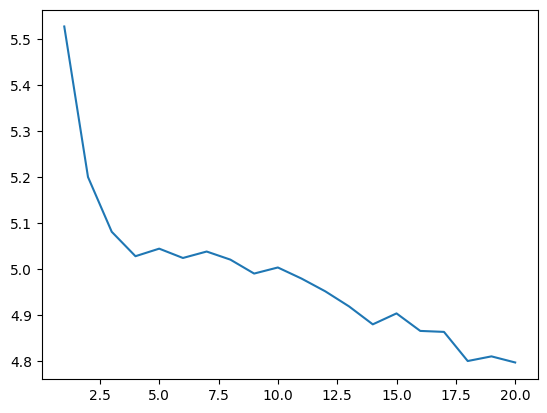

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://596280583af5960044.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://596280583af5960044.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='por eso el nombre de lidenbrock gozaba de gran'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'por eso el nombre de lidenbrock gozaba de granito de la casa de la casa de l'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="por eso el nombre de lidenbrock gozaba de gran",temp=0.5,mode='sto')

In [ ]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

por eso el nombre de lidenbrock gozaba de granito de la marcha del
por eso el nombre de lidenbrock gozaba de granito de la marcha de 
por eso el nombre de lidenbrock gozaba de granito de la marcha, y 
por eso el nombre de lidenbrock gozaba de granito de la marcha, y 
por eso el nombre de lidenbrock gozaba de granito de la marcha de 


In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="por eso el nombre de lidenbrock gozaba de gran",temp=10,mode='sto')

In [ ]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

por eso el nombre de lidenbrock gozaba de gransá, céjabbu;eff/ir”m
por eso el nombre de lidenbrock gozaba de gransá, céjabbu;eff/iri?
por eso el nombre de lidenbrock gozaba de gransá, céjabbu;effu l“o
por eso el nombre de lidenbrock gozaba de gransá, céjabbu;eff/ir”“
por eso el nombre de lidenbrock gozaba de gransá, céjabbu;effm‑úñ,


##Conclusiones

A pesar de que el entrenamiento del modelo llegó a un valor ciertamente razonable 4.79 con un vocabulario de 76, no fue suficiente para dar buenos resultados de predicción.

Habria que evaluar bien como se esta calculando la perplejidad.

Por otro lado se puede intentar con mas modificaciones a la arquitectura para ver si converge mejor el modelo.

El modelo tiene un comportamiento mas "razonable" con una temperatura que hace tender al modelo a ser mas greddy search o mas determinista, pero de igual forma se resalta que no tiene gran sentido lo que se logra predecir.

Otra cosa a probar es eliminar los acentos en la etapa de preprocesamiento y ver si tiene un mejor comportamiento el modelo.

Por ultimo pero no menos importante, es que quizas aunque el dataset es un libro y tiene una cantidad de terminos considerables, probablemente sigue siendo poco para poder darle referencia a un modelo sobre las complejidades semanticas de un idioma como el español, tranquilamente la seccion tomada en validacion puede tener secuencias de palabras que quizas nunca vio en entrenamiento, quizas tiene las mismas palabras pero en secuencias distintas que hacen que el signficado sea distinto, por lo que puede faltar muchas mas referencias para tener una respuesta adecuada.